In [1]:
exec(open('libraries.py').read())
%matplotlib inline
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [2]:
cliente_tabla = pd.read_csv('../data/cliente_tabla.csv')
producto_tabla = pd.read_csv('../data/producto_tabla.csv')
test = pd.read_csv('../data/test.csv')
train = pd.read_csv('../data/train.csv')
town_state = pd.read_csv('../data/town_state.csv')
client_info = pd.read_csv('../data/Derived/client_info.csv')
pivot_test_train = pd.read_csv('../data/Derived/pivot_test_train.csv')

In [3]:
pivot_test_train = pd.merge(pivot_test_train, 
            client_info[['MC_Ruta', 'MC_Agencia', 'Cliente_ID', 'N_rutas', 'N_Agencias', 'Town']], how = 'left', 
         left_on='Cliente_ID', right_on='Cliente_ID' )
pivot_test_train.head()

,Cliente_ID,Producto_ID,sem3,sem4,sem5,sem6,sem7,sem8,sem9,sem10,sem11,MC_Ruta,MC_Agencia,N_rutas,N_Agencias,Town
0,26,1182,39,NaN,NaN,NaN,0,0,NaN,NaN,NaN,7212,2061,6,2,2175 TOLUCA AEROPUERTO
1,26,4767,42,NaN,NaN,NaN,42,42,NaN,NaN,NaN,7212,2061,6,2,2175 TOLUCA AEROPUERTO
2,26,30235,NaN,NaN,NaN,NaN,NaN,NaN,96,NaN,NaN,7212,2061,6,2,2175 TOLUCA AEROPUERTO
3,26,30314,NaN,NaN,NaN,NaN,48,NaN,NaN,NaN,NaN,7212,2061,6,2,2175 TOLUCA AEROPUERTO
4,26,31393,20,16,15,15,18,22,13,NaN,NaN,7212,2061,6,2,2175 TOLUCA AEROPUERTO


In [4]:
train = pd.merge(train, 
            client_info[['MC_Ruta', 'MC_Agencia', 'Cliente_ID', 'N_rutas', 'N_Agencias', 'Town']], how = 'left', 
         left_on='Cliente_ID', right_on='Cliente_ID' )
train.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,MC_Ruta,MC_Agencia,N_rutas,N_Agencias,Town
0,3,1110,7,3301,15766,1212,3,25.14,0,0,3,3301,1110,1,1,2008 AG. LAGO FILT
1,3,1110,7,3301,15766,1216,4,33.52,0,0,4,3301,1110,1,1,2008 AG. LAGO FILT
2,3,1110,7,3301,15766,1238,4,39.32,0,0,4,3301,1110,1,1,2008 AG. LAGO FILT
3,3,1110,7,3301,15766,1240,4,33.52,0,0,4,3301,1110,1,1,2008 AG. LAGO FILT
4,3,1110,7,3301,15766,1242,3,22.92,0,0,3,3301,1110,1,1,2008 AG. LAGO FILT


# 0. Help functions

In this notebook, we will tryout a simple XGBoost model<br>

In [12]:
def groupby_and_aggregate(subset_df, pivot_df):
    start = time.time()
    # Group by product and client
    grouped_by_prod_client = subset_df[['Cliente_ID', 'Producto_ID','Demanda_uni_equil']].groupby(['Producto_ID', 'Cliente_ID'])
    grouped_by_prod_client = grouped_by_prod_client.aggregate('median').rename(columns={'Demanda_uni_equil': 'Lookup_demand_Prod_Client'})
    pivot_df = pd.merge(pivot_df, grouped_by_prod_client, how = 'left', left_on = ['Producto_ID', 'Cliente_ID'], right_index = True)
    # Groupby product and town  
    grouped_by_prod_town = subset_df[['Producto_ID', 'Town', 'Demanda_uni_equil']].groupby(['Producto_ID', 'Town'])
    grouped_by_prod_town = grouped_by_prod_town.aggregate('median').rename(columns={'Demanda_uni_equil': 'Lookup_demand_Prod_Town'})
    pivot_df = pd.merge(pivot_df, grouped_by_prod_town, how = 'left', left_on = ['Producto_ID', 'Town'], right_index = True)     
    # Group by product
    grouped_by_prod = subset_df[['Producto_ID', 'Demanda_uni_equil']].groupby(['Producto_ID'])
    grouped_by_prod = grouped_by_prod.aggregate('median').rename(columns={'Demanda_uni_equil': 'Lookup_demand_Prod'})
    pivot_df = pd.merge(pivot_df, grouped_by_prod, how = 'left', left_on = ['Producto_ID'], right_index = True)
    # Group by client, median per client
    grouped_by_client = subset_df[['Cliente_ID', 'Demanda_uni_equil']].groupby(['Cliente_ID'])
    grouped_by_client_median = grouped_by_client.aggregate('median').rename(columns={'Demanda_uni_equil': 'Lookup_demand_Client'})
    pivot_df = pd.merge(pivot_df, grouped_by_client_median, how = 'left', left_on = ['Cliente_ID'], right_index = True)
    # Group by client, sum and average store size
    grouped_by_client_sum = grouped_by_client.aggregate('sum')
    grouped_by_client_sum['log_Demanda_uni_equil'] = np.log(grouped_by_client_sum['Demanda_uni_equil'] + 1)
    grouped_by_client_sum['rel_store_size'] = np.argsort(grouped_by_client_sum['log_Demanda_uni_equil'].values)/len(grouped_by_client_sum)
    pivot_df = pd.merge(pivot_df, grouped_by_client_sum[['rel_store_size']], how = 'left', left_on = 'Cliente_ID', right_index = True)
    # Make some corrections
    #pivot_df['Lookup_demand_Prod_corr'] = pivot_df['Lookup_demand_Prod'] * pivot_df['Lookup_demand_Client'] / subset_df['Demanda_uni_equil'].median()
    
    print('Time spend grouping and aggregating = %f seconds' %np.round((time.time() - start ), 1))
    
    return pivot_df

In [6]:
def define_time_features(df, to_predict = 't_plus_1' , t_0 = 8):
    start = time.time()
    if(to_predict == 't_plus_1' ):
        df['t_min_1'] = df['sem'+str(t_0-1)]
    
    df['t_min_2'] = df['sem'+str(t_0-2)]
    df['t_min_3'] = df['sem'+str(t_0-3)]
    df['t_min_4'] = df['sem'+str(t_0-4)]
    df['t_min_5'] = df['sem'+str(t_0-5)]
    
    if(to_predict == 't_plus_1' ):
        df['t1_min_t2'] =  df['t_min_1'] - df['t_min_2']
        df['t1_min_t3'] =  df['t_min_1'] - df['t_min_3']
        df['t1_min_t4'] =  df['t_min_1'] - df['t_min_4']
        df['t1_min_t5'] =  df['t_min_1'] - df['t_min_5']

    df['t2_min_t3'] =  df['t_min_2'] - df['t_min_3']
    df['t2_min_t4'] =  df['t_min_2'] - df['t_min_4']
    df['t2_min_t5'] =  df['t_min_2'] - df['t_min_5']

    df['t3_min_t4'] =  df['t_min_3'] - df['t_min_4']
    df['t3_min_t5'] =  df['t_min_3'] - df['t_min_5']

    df['t4_min_t5'] =  df['t_min_4'] - df['t_min_5']
    print('Time spend renaming the columns to time features = %f seconds' %np.round((time.time() - start ), 1))  
    return df 

In [1]:
def lin_regr(row, to_predict, t_0, semanas_numbers):
    row = row.copy()
    row.index = semanas_numbers
    row = row.dropna()
    if(len(row>2)):
        X = np.ones(shape=(len(row), 2))
        X[:,1] = row.index
        y = row.values
        regr = linear_model.LinearRegression()
        regr.fit(X, y)
        if(to_predict == 't_plus_1'):
            return regr.predict([[1,t_0+1]])[0]
        elif(to_predict == 't_plus_2'):
            return regr.predict([[1,t_0+2]])[0]
    else:
        return None

In [15]:
def lin_regr_features(pivot_df, semanas_numbers):
    start = time.time()
    semanas_names = ['sem%i' %i for i in semanas_numbers].copy()
    columns = semanas_names.copy()
    columns.append('Producto_ID')
    pivot_grouped = pivot_df[columns].groupby('Producto_ID').aggregate('median')
    pivot_grouped['LR_prod'] = np.zeros(len(pivot_grouped))
    pivot_grouped['LR_prod'] = pivot_grouped[semanas_names].apply(lin_regr, axis = 1, to_predict = 't_plus_1', t_0 = 7, semanas_numbers = semanas_numbers )
    pivot_df = pd.merge(pivot_df, pivot_grouped[['LR_prod']], how='left', left_on = 'Producto_ID', right_index=True)
    pivot_df['LR_prod_corr'] = pivot_df['LR_prod'] * pivot_df['rel_store_size'] / 100
    print('Time spend linear regression features = %f seconds' %np.round((time.time() - start ), 1))
    return pivot_df

# 1. Feature matrix to predict t+1

train_pivot_8 is a dataframe to train a model on week 8<br>
features are build with features of week 3,4,5,6,7 <br><br>
train_pivot_9 is a dataframe to train a model on week 9<br>
features are build with features of week 4,5,6,7,8 <br>

#### Pivot 8

In [ ]:
try:
    del train_34567
    del train_pivot_8
    gc.collect() 
except:
    pass

# Prepare groupby features
train_34567 = train.loc[train['Semana'].isin([3,4,5,6,7]), :].copy()
#train_34567 = train_34567.sample(10000000)
print('Subset is taken')
# Subset of training pivot
train_pivot_8 = pivot_test_train.loc[(pivot_test_train['sem8'].notnull()),:].copy()
#train_pivot_8 = train_pivot_8.sample(10000000)
train_pivot_8 = train_pivot_8[['Cliente_ID', 'Producto_ID', 'Town','sem3', 'sem4', 'sem5', 'sem6', 'sem7', 'sem8']]
print('Subset of training is taken')
# Rename features
train_pivot_8 = define_time_features(train_pivot_8, to_predict = 't_plus_1' , t_0 = 8)
# Group by features
train_pivot_8 = groupby_and_aggregate(train_34567, train_pivot_8)
# Free memory
del train_34567
gc.collect()
# Linear regression features 
train_pivot_8 = lin_regr_features(train_pivot_8, semanas_numbers = [3,4,5,6,7])
# Convert outcome variable
#train_pivot_8['logt0'] = np.log(train_pivot_8['sem8']+1)

train_pivot_8.sample(5)

Subset is taken
Subset of training is taken
Time spend renaming the columns to time features = 0.600000 seconds
Time spend grouping and aggregating = 55.600000 seconds


In [14]:
train_pivot_8 = train_pivot_8.drop('Town', axis = 1)

### Pivot 9

In [209]:
# Prepare groupby features
train_45678 = train.loc[train['Semana'].isin([4,5,6,7,8]), :].copy()
# Subset of training pivot
train_pivot_9 = train_pivot.loc[(train_pivot['sem9'].notnull()),:].copy()
train_pivot_9 = train_pivot_9[['Cliente_ID', 'Producto_ID',  'sem4', 'sem5', 'sem6', 'sem7', 'sem8', 'sem9']]
# Rename features
train_pivot_9 = define_time_features(train_pivot_9, to_predict = 't_plus_1' , t_0 = 9)
# Group by features
train_pivot_9 = groupby_and_aggregate(train_45678, train_pivot_9)
# Linear regression features 
train_pivot_9 = lin_regr_features(train_pivot_9, semanas_numbers = [4,5,6,7,8])
# Convert outcome variable
train_pivot_9['logt0'] = np.log(train_pivot_9['sem9']+1)
# Free up memory
del train_45678
gc.collect()

train_pivot_9.sample(5)

Time spend grouping and aggregating = 122.000000 seconds
Time spend linear regression features = 28.700000 seconds


,Cliente_ID,Producto_ID,sem4,sem5,sem6,sem7,sem8,sem9,t_min_1,t_min_2,t_min_3,t_min_4,t_min_5,t1_min_t2,t1_min_t3,t1_min_t4,t1_min_t5,t2_min_t3,t2_min_t4,t2_min_t5,t3_min_t4,t3_min_t5,t4_min_t5,Lookup_demand_Prod_Client,Lookup_demand_Prod,Lookup_demand_Client,rel_store_size,Lookup_demand_Prod_corr,LR_prod,LR_prod_corr,logt0
25349408,7815815,40450,161.0,264.0,NaN,NaN,192.0,115.0,192.0,NaN,NaN,264.0,161.0,NaN,NaN,-72.0,31.0,NaN,NaN,NaN,NaN,NaN,103.0,192.0,6.0,48.0,0.371035,96.0,7.4,0.027457,4.753590
7913640,539746,3631,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,0.270259,2.0,2.0,0.005405,0.693147
442958,28721,37005,10.0,28.0,25.0,NaN,25.0,23.0,25.0,NaN,25.0,28.0,10.0,NaN,0.0,-3.0,15.0,NaN,NaN,NaN,-3.0,15.0,18.0,25.0,14.0,9.0,0.929968,42.0,14.6,0.135775,3.178054
4099373,229344,1309,9.0,4.0,11.0,9.0,5.0,2.0,5.0,9.0,11.0,4.0,9.0,-4.0,-6.0,1.0,-4.0,-2.0,5.0,0.0,7.0,2.0,-5.0,9.0,3.0,4.0,0.778121,4.0,3.0,0.023344,1.098612
9472555,716839,34213,6.0,7.0,11.0,6.0,8.0,14.0,8.0,6.0,11.0,7.0,6.0,2.0,-3.0,1.0,2.0,-5.0,-1.0,0.0,4.0,5.0,1.0,7.0,3.0,4.0,0.894082,4.0,3.0,0.026822,2.708050


### Combine training pivots 8 and 9

In [219]:
selection = ['t_min_1', 't_min_2', 't_min_3','t_min_4','t_min_5',
             't1_min_t2','t1_min_t3','t1_min_t4','t1_min_t5', 
              't2_min_t3', 't2_min_t4', 't2_min_t5',
                 't3_min_t4','t3_min_t5',
                         't4_min_t5',
                         'Lookup_demand_Prod_Client','Lookup_demand_Prod','Lookup_demand_Client', 'Lookup_demand_Prod_corr',
             'LR_prod','LR_prod_corr','rel_store_size','Lookup_demand_Prod_Town',
             'logt0']
train_pivot_xgb = pd.concat([train_pivot_8[selection], train_pivot_9[selection]], axis = 0)

#del train_pivot_8
#del train_pivot_9
#gc.collect()

KeyError: "['Lookup_demand_Prod_Town'] not in index"

### test Pivot 10

In [12]:
# Prepare groupby features
train_56789 = train.loc[train['Semana'].isin([5,6,7,8,9]), :].copy()
grouped_by_prod_client, grouped_by_prod, grouped_by_client = groupby_and_aggregate(train_56789)
del train_56789
gc.collect()
# Prepare test pivot
test_pivot_10 = test_pivot.loc[test_pivot['Semana'] == 10,:].copy()
test_pivot_10 = test_pivot_10[['id','Cliente_ID', 'Producto_ID', 'sem5', 'sem6', 'sem7', 'sem8', 'sem9']]
# Rename features
test_pivot_10 = define_time_features(test_pivot_10, to_predict = 't_plus_1' , t_0 = 10)
# Merge with groupby features
test_pivot_10 = pd.merge(test_pivot_10, grouped_by_prod_client, how = 'left', left_on = ['Producto_ID', 'Cliente_ID'], right_index = True)
test_pivot_10 = pd.merge(test_pivot_10, grouped_by_prod, how = 'left', left_on = ['Producto_ID'], right_index = True)
test_pivot_10 = pd.merge(test_pivot_10, grouped_by_client, how = 'left', left_on = ['Cliente_ID'], right_index = True)

test_pivot_10.sample(5)

Time spend grouping and aggregating = 91.600000 seconds


,id,Cliente_ID,Producto_ID,sem5,sem6,sem7,sem8,sem9,t_min_1,t_min_2,t_min_3,t_min_4,t_min_5,t1_min_t2,t1_min_t3,t1_min_t4,t1_min_t5,t2_min_t3,t2_min_t4,t2_min_t5,t3_min_t4,t3_min_t5,t4_min_t5,Lookup_demand_Prod_Client,Lookup_demand_Client_Prod,Lookup_demand_Prod,Lookup_demand_Client
2037956,2037956,2101017,43200,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,2.0,4.0
2781967,2781967,856264,37361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0
2433922,2433922,258816,2425,15.0,42.0,20.0,40.0,15.0,15.0,40.0,20.0,42.0,15.0,-25.0,-5.0,-27.0,0.0,20.0,-2.0,25.0,-22.0,5.0,27.0,20.0,20.0,20.0,2.0
6870986,6870986,1457795,37361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0
620832,620832,508458,43201,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0


## XGboost for t+1

In [211]:
predictors = ['t_min_1', 't_min_2', 't_min_3','t_min_4','t_min_5',
             't1_min_t2','t1_min_t3','t1_min_t4','t1_min_t5', 
              't2_min_t3', 't2_min_t4', 't2_min_t5',
                 't3_min_t4','t3_min_t5',
 't4_min_t5','Lookup_demand_Prod_Client','Lookup_demand_Prod','Lookup_demand_Client', 'Lookup_demand_Prod_corr','LR_prod','LR_prod_corr']

In [212]:
target = 'logt0'
train_pivot_xgb_sample = train_pivot_xgb.sample(1000000)
dtrain = xgb.DMatrix(train_pivot_xgb_sample[predictors], label=train_pivot_xgb_sample['logt0'], missing=np.nan)
param = {'eta':0.1, 'eval_metric':'rmse'}
num_boost_round = 50
cvresult = xgb.cv(param, dtrain, num_boost_round, nfold=5,show_progress=True,show_stdv=False,
                        seed = 0, early_stopping_rounds=5)
print(cvresult.tail())


Will train until cv error hasn't decreased in 5 rounds.
[0]	cv-test-rmse:1.2512442000000001	cv-train-rmse:1.2501612000000002
[1]	cv-test-rmse:1.1457029999999997	cv-train-rmse:1.1451031999999999
[2]	cv-test-rmse:1.0523436	cv-train-rmse:1.0519748
[3]	cv-test-rmse:0.9700886000000001	cv-train-rmse:0.9699401999999999
[4]	cv-test-rmse:0.8980018	cv-train-rmse:0.8976706
[5]	cv-test-rmse:0.8349091999999999	cv-train-rmse:0.8345993999999999
[6]	cv-test-rmse:0.7800544	cv-train-rmse:0.7796676
[7]	cv-test-rmse:0.7324486	cv-train-rmse:0.7320348000000001
[8]	cv-test-rmse:0.6914359999999999	cv-train-rmse:0.6909997999999999
[9]	cv-test-rmse:0.6562496	cv-train-rmse:0.6556888
[10]	cv-test-rmse:0.626148	cv-train-rmse:0.6255882
[11]	cv-test-rmse:0.6006752	cv-train-rmse:0.6000023999999999
[12]	cv-test-rmse:0.579094	cv-train-rmse:0.5783862
[13]	cv-test-rmse:0.5609128	cv-train-rmse:0.560164
[14]	cv-test-rmse:0.5456962000000001	cv-train-rmse:0.5448878
[15]	cv-test-rmse:0.5329458	cv-train-rmse:0.5320688
[16]	cv-

    test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
45        0.470041       0.000756         0.467781        0.000200
46        0.469956       0.000761         0.467646        0.000203
47        0.469874       0.000759         0.467525        0.000204
48        0.469798       0.000770         0.467403        0.000198
49        0.469720       0.000728         0.467278        0.000229


[49]	cv-test-rmse:0.46972	cv-train-rmse:0.46727799999999997


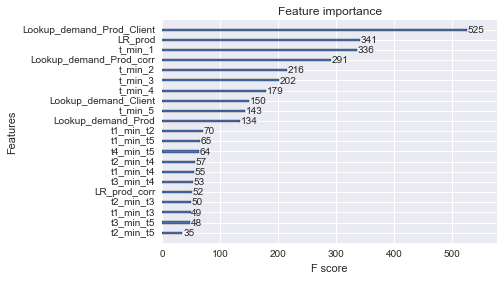

In [213]:
# specify parameters via map
param = {'eta':0.1, 'silent':0, 'objective':'reg:linear', 'eval_metric':'rmse' }
num_round = cvresult.shape[0]
bst = xgb.train(param, dtrain, num_round)
xgb.plot_importance(bst)

In [ ]:
# make prediction
dtest = xgb.DMatrix(test_pivot_10[predictors], missing=np.nan)
submission_10 = test_pivot_10[['id']].copy()
submission_10['predict'] = bst.predict(dtest)

# 2. Same story for t+2

train_pivot_8 is a dataframe to train a model on week 8<br>
features are build with features of week 3,4,5,6 <br><br>
train_pivot_9 is a dataframe to train a model on week 9<br>
features are build with features of week 4,5,6,7 <br>

### pivot 8

In [34]:
# Prepare dataframe for grouping
train_3456 = train.loc[train['Semana'].isin([3,4,5,6]), :].copy()
grouped_by_prod_client, grouped_by_prod, grouped_by_client = groupby_and_aggregate(train_3456)
del train_3456
gc.collect()

# Subset of training pivot
train_pivot_8 = train_pivot.loc[(train_pivot['sem8'].notnull()),:].copy()
train_pivot_8 = train_pivot_8[['Cliente_ID', 'Producto_ID', 'sem3', 'sem4', 'sem5', 'sem6','sem8']]
# Rename features
train_pivot_8 = define_time_features(train_pivot_8, to_predict = 't_plus_2' , t_0 = 8)
# Merge with groupby features
train_pivot_8 = pd.merge(train_pivot_8, grouped_by_prod_client, how = 'left', left_on = ['Producto_ID', 'Cliente_ID'], right_index = True)
train_pivot_8 = pd.merge(train_pivot_8, grouped_by_prod, how = 'left', left_on = ['Producto_ID'], right_index = True)
train_pivot_8 = pd.merge(train_pivot_8, grouped_by_client, how = 'left', left_on = ['Cliente_ID'], right_index = True)
# Convert outcome variable
train_pivot_8['logt0'] = np.log(train_pivot_8['sem8']+1)

train_pivot_8.head()

Time spend grouping and aggregating = 41.000000 seconds


,Cliente_ID,Producto_ID,sem3,sem4,sem5,sem6,sem8,t_min_2,t_min_3,t_min_4,t_min_5,t2_min_t3,t2_min_t4,t2_min_t5,t3_min_t4,t3_min_t5,t4_min_t5,Lookup_demand_Prod_Client,Lookup_demand_Prod,Lookup_demand_Client,logt0
0,26,1182,39.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,39.0,NaN,NaN,NaN,NaN,NaN,NaN,39.0,4.0,19.0,0.000000
1,26,4767,42.0,NaN,NaN,NaN,42.0,NaN,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,42.0,3.0,19.0,3.761200
4,26,31393,20.0,16.0,15.0,15.0,22.0,15.0,15.0,16.0,20.0,0.0,-1.0,-5.0,-1.0,-5.0,-4.0,15.5,2.0,19.0,3.135494
11,26,34204,43.0,30.0,44.0,34.0,45.0,34.0,44.0,30.0,43.0,-10.0,4.0,-9.0,14.0,1.0,-13.0,38.5,16.0,19.0,3.828641
12,26,34206,120.0,81.0,42.0,69.0,89.0,69.0,42.0,81.0,120.0,27.0,-12.0,-51.0,-39.0,-78.0,-39.0,75.0,3.0,19.0,4.499810


### pivot 9

In [35]:
# Prepare dataframe for grouping
train_4567 = train.loc[train['Semana'].isin([4,5,6,7]), :].copy()
grouped_by_prod_client, grouped_by_prod, grouped_by_client = groupby_and_aggregate(train_4567)
del train_4567
gc.collect()

# Subset of training pivot
train_pivot_9 = train_pivot.loc[(train_pivot['sem9'].notnull()),:].copy()
train_pivot_9 = train_pivot_9[['Cliente_ID', 'Producto_ID',  'sem4', 'sem5', 'sem6', 'sem7', 'sem9']]
# Rename features
train_pivot_9 = define_time_features(train_pivot_9, to_predict = 't_plus_2' , t_0 = 9)
# Merge with groupby features
train_pivot_9 = pd.merge(train_pivot_9, grouped_by_prod_client, how = 'left', left_on = ['Producto_ID', 'Cliente_ID'], right_index = True)
train_pivot_9 = pd.merge(train_pivot_9, grouped_by_prod, how = 'left', left_on = ['Producto_ID'], right_index = True)
train_pivot_9 = pd.merge(train_pivot_9, grouped_by_client, how = 'left', left_on = ['Cliente_ID'], right_index = True)
# Convert outcome variable
train_pivot_9['logt0'] = np.log(train_pivot_9['sem9']+1)

train_pivot_9.head()

Time spend grouping and aggregating = 38.800000 seconds


,Cliente_ID,Producto_ID,sem4,sem5,sem6,sem7,sem9,t_min_2,t_min_3,t_min_4,t_min_5,t2_min_t3,t2_min_t4,t2_min_t5,t3_min_t4,t3_min_t5,t4_min_t5,Lookup_demand_Prod_Client,Lookup_demand_Prod,Lookup_demand_Client,logt0
2,26,30235,NaN,NaN,NaN,NaN,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,18.0,4.574711
4,26,31393,16.0,15.0,15.0,18.0,13.0,18.0,15.0,15.0,16.0,3.0,3.0,2.0,0.0,-1.0,-1.0,15.5,2.0,18.0,2.639057
8,26,32962,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,18.0,2.397895
11,26,34204,30.0,44.0,34.0,36.0,43.0,36.0,34.0,44.0,30.0,2.0,-8.0,6.0,-10.0,4.0,14.0,35.0,16.0,18.0,3.784190
12,26,34206,81.0,42.0,69.0,96.0,107.0,96.0,69.0,42.0,81.0,27.0,54.0,15.0,27.0,-12.0,-39.0,75.0,2.0,18.0,4.682131


### Combine the two pivots

In [37]:
selection = [ 't_min_2', 't_min_3','t_min_4','t_min_5',
              't2_min_t3', 't2_min_t4', 't2_min_t5',
                 't3_min_t4','t3_min_t5',
 't4_min_t5','Lookup_demand_Prod_Client','Lookup_demand_Prod','Lookup_demand_Client', 'logt0']
train_pivot_xgb = pd.concat([train_pivot_8, train_pivot_9],axis = 0)
del train_pivot_8
del train_pivot_9
gc.collect()

440

### test Pivot 11 

In [36]:
# Prepare dataframe for grouping
train_6789 = train.loc[train['Semana'].isin([6,7,8,9]), :].copy()
grouped_by_prod_client,  grouped_by_prod, grouped_by_client = groupby_and_aggregate(train_6789)
del train_6789
gc.collect()

# Prepare test pivot
test_pivot_11 = test_pivot.loc[test_pivot['Semana'] == 11,:]
test_pivot_11 = test_pivot_11[['id','Cliente_ID', 'Producto_ID',  'sem6', 'sem7', 'sem8', 'sem9']]
# Rename features
test_pivot_11 = define_time_features(test_pivot_11, to_predict = 't_plus_2' , t_0 = 11)
# Merge with groupby features
test_pivot_11 = pd.merge(test_pivot_11, grouped_by_prod_client, how = 'left', left_on = ['Producto_ID', 'Cliente_ID'], right_index = True)
test_pivot_11 = pd.merge(test_pivot_11, grouped_by_prod, how = 'left', left_on = ['Producto_ID'], right_index = True)
test_pivot_11 = pd.merge(test_pivot_11, grouped_by_client, how = 'left', left_on = ['Cliente_ID'], right_index = True)

test_pivot_11.head()

Time spend grouping and aggregating = 37.500000 seconds


,id,Cliente_ID,Producto_ID,sem6,sem7,sem8,sem9,t_min_2,t_min_3,t_min_4,t_min_5,t2_min_t3,t2_min_t4,t2_min_t5,t3_min_t4,t3_min_t5,t4_min_t5,Lookup_demand_Prod_Client,Lookup_demand_Prod,Lookup_demand_Client
0,0,4639078,35305,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.0,2.0
1,1,4705135,1238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0
3,3,4717855,43066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0
4,4,966351,1277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0
5,5,1741414,972,NaN,3.0,4.0,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.5,2.0,8.0


## Xgboost t+2

In [38]:
predictors = ['t_min_2', 't_min_3','t_min_4','t_min_5',
              't2_min_t3', 't2_min_t4', 't2_min_t5',
                 't3_min_t4','t3_min_t5',
 't4_min_t5','Lookup_demand_Prod_Client','Lookup_demand_Prod','Lookup_demand_Client']
target = 'logt0'
train_pivot_xgb_sample = train_pivot_xgb.sample(1000000)
dtrain = xgb.DMatrix(train_pivot_xgb_sample[predictors], label=train_pivot_xgb_sample['logt0'], missing=np.nan)
param = {'eta':0.1, 'eval_metric':'rmse'}
num_boost_round = 500
cvresult = xgb.cv(param, dtrain, num_boost_round, nfold=5,show_progress=True,show_stdv=False,
                        seed = 0, early_stopping_rounds=5)
print(cvresult.tail())


Will train until cv error hasn't decreased in 5 rounds.
[0]	cv-test-rmse:1.2548219999999999	cv-train-rmse:1.2538938000000002
[1]	cv-test-rmse:1.150544	cv-train-rmse:1.1502134
[2]	cv-test-rmse:1.0585454	cv-train-rmse:1.0582424
[3]	cv-test-rmse:0.9773806	cv-train-rmse:0.9770427999999999
[4]	cv-test-rmse:0.906241	cv-train-rmse:0.905968
[5]	cv-test-rmse:0.8442575999999999	cv-train-rmse:0.8439868
[6]	cv-test-rmse:0.7902205999999999	cv-train-rmse:0.7899385999999999
[7]	cv-test-rmse:0.7434841999999999	cv-train-rmse:0.7430876
[8]	cv-test-rmse:0.7031824	cv-train-rmse:0.7027802
[9]	cv-test-rmse:0.6686744	cv-train-rmse:0.668189
[10]	cv-test-rmse:0.6392838	cv-train-rmse:0.6387542
[11]	cv-test-rmse:0.6143596	cv-train-rmse:0.6138016000000001
[12]	cv-test-rmse:0.5933628000000001	cv-train-rmse:0.5927042
[13]	cv-test-rmse:0.5756393999999999	cv-train-rmse:0.575068
[14]	cv-test-rmse:0.5607987999999999	cv-train-rmse:0.5601656
[15]	cv-test-rmse:0.5484396	cv-train-rmse:0.5477998000000001
[16]	cv-test-rmse:0

KeyboardInterrupt: 

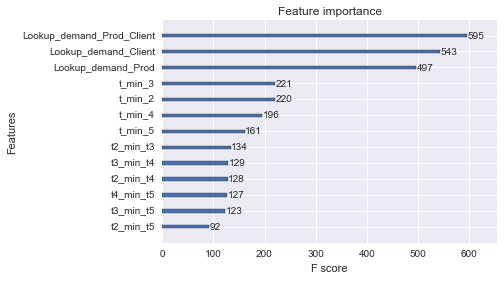

In [39]:
# specify parameters via map
param = {'eta':0.1, 'silent':0, 'objective':'reg:linear', 'eval_metric':'rmse' }
num_round = cvresult.shape[0]
bst = xgb.train(param, dtrain, num_round)
# make prediction
dtest = xgb.DMatrix(test_pivot_11[predictors], missing=np.nan)
submission_11 = test_pivot_11[['id']].copy()
submission_11['predict'] = bst.predict(dtest)
xgb.plot_importance(bst)

# 3. Join and create submission file

In [40]:
submission = pd.concat([submission_10[['id', 'predict']],submission_11[['id', 'predict']]], axis = 0)
submission['predict'] = np.exp(submission['predict']) - 1
submission['predict'] = np.round(submission['predict'].values, 1)
submission = submission.rename(columns = {'predict':'Demanda_uni_equil'})
submission = submission.sort_values(by = 'id')
submission.head(20)

,id,Demanda_uni_equil
0,0,4.2
1,1,1.3
2,2,2.4
3,3,1.5
4,4,2.3
5,5,3.1
6,6,1.6
7,7,7.2
8,8,4.2
9,9,4.9


In [41]:
submission.to_csv('xgb_2_submission.csv', index=False, float_format='%.1f')

In [89]:
temp_client = train.loc[train['Cliente_ID']==333576,:]
temp_client_product = temp_client.loc[temp_client['Producto_ID']==1238,:]
temp_client_product

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
2298988,3,1235,1,1107,333576,1238,1,9.83,0,0.00,1
13389461,4,1235,1,1107,333576,1238,1,9.83,2,19.66,0
24239560,5,1235,1,1107,333576,1238,2,19.66,1,9.83,1
34746655,6,1235,1,1107,333576,1238,0,0.00,3,29.49,0


In [90]:
client_15766 = train.loc[(train['Cliente_ID']==15766) & (train['Producto_ID']==1216),:]
client_15766

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4
11165210,4,1110,7,3301,15766,1216,2,16.76,0,0.0,2
22174801,5,1110,7,3301,15766,1216,3,25.14,0,0.0,3
32790197,6,1110,7,3301,15766,1216,1,8.38,0,0.0,1
42982034,7,1110,7,3301,15766,1216,2,16.76,0,0.0,2
53364884,8,1110,7,3301,15766,1216,5,41.90,0,0.0,5


,Demanda_uni_equil,log_Demanda_uni_equil
Cliente_ID,,
26,1234,7.118826
60,9889,9.199279
65,9226,9.129889
101,148,5.003946
105,2013,7.607878


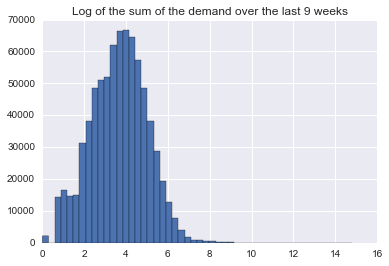

In [92]:
train_9 = train.loc[train['Semana'] == 9,:]
grouped_by_client = train_9[['Cliente_ID', 'Demanda_uni_equil']].groupby('Cliente_ID').aggregate('sum')
grouped_by_client['log_Demanda_uni_equil'] = np.log(grouped_by_client['Demanda_uni_equil'] + 1)
grouped_by_client['log_Demanda_uni_equil'].hist(bins = 50)
plt.title('Log of the sum of the demand over the last 9 weeks')
grouped_by_client.head()

In [94]:
town_state.head()

,Agencia_ID,Town,State
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F."
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
3,1113,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F."
